In [1]:
# import neuron
from neuron import h

try:
    h.nrn_load_dll("../Models/Sanjay_model/x86_64/libnrnmech.so")  # load the mod files
except:
    pass

h.load_file("stdrun.hoc")  # load the standard run file
h.tstop = 5000  # set the simulation time

--No graphics will be displayed.


In [2]:
# from SynapticaSims import Plotting
# import pickle

In [3]:
# with open(f"{data_directory}/09.pkl", 'rb') as f:
#     data = pickle.load(f)

# data = data['simData']

# cells = [cell for _, cell in data.items()]
# Plotting.plot_spikes(cells, title="Spike raster plot of the network")

In [4]:
# data = {'0': simData}

# def compute_lfp(data):
#     pass

# compute_lfp(data['0'])

numprocs=1


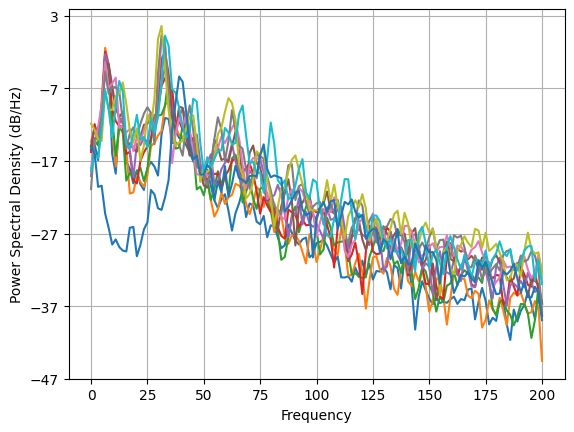

In [5]:
# important imports
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sys

# Add the path to the code directory to the system path
sys.path.append(
"/home/Marc/Marc_network_sims",)  # Add the path to the 'src' parent directory

# Define the path to the data directory
data_directory = "../data/Data03_model_validation/"

# Lists to store the calculated information for each file
pyr_mean_firing_rates_list = []
bwb_mean_firing_rates_list = []
olm_mean_firing_rates_list = []

pyr_std_firing_rates_list = []
bwb_std_firing_rates_list = []
olm_std_firing_rates_list = []

lfps_list = []

gamma_frequencies_list = []
theta_frequencies_list = []

mean_gamma_power_list = []
mean_theta_power_list = []

# Iterate over the file names from 00.pkl to 10.pkl
for i in range(11):  # Assuming you want to include 10.pkl
    filename = f"{i:02d}.pkl"  # Format the filename with leading zeros
    file_path = os.path.join(data_directory, filename)

    # Check if the file exists before attempting to load it
    if os.path.exists(file_path):
        with open(file_path, "rb") as f:
            data = pickle.load(f)

            # Add your analysis code here
            # Acess simData in data
            simData = data["simData"]

            gid = 0
            if gid in simData:
                neuron_data = simData[gid]

            # define pyr cells using list comprehension
            pyr_cells = [cell for gid, cell in simData.items() if cell._gid < 800]
            bwb_cells = [
                cell for gid, cell in simData.items() if 800 <= cell._gid < 1000
            ]
            olm_cells = [
                cell for gid, cell in simData.items() if 1000 <= cell._gid < 1200
            ]

            # ////////////////////////////////////////////////////////////////////////////
            # Compute firing rates for each population
            from src.SanjayCode import compute_population_firing_rates

            # Flatten and concatenate spike times
            pyr_spike_times = np.concatenate([cell.spike_times for cell in pyr_cells])
            bwb_spike_times = np.concatenate([cell.spike_times for cell in bwb_cells])
            olm_spike_times = np.concatenate([cell.spike_times for cell in olm_cells])

            # Simulation parameters
            simulation_duration = 5000  # in milliseconds
            dt = 0.1  # time step in milliseconds

            # Compute firing rates for each population
            pyr_mean, pyr_std = compute_population_firing_rates(
                pyr_cells, simulation_duration, dt
            )
            bwb_mean, bwb_std = compute_population_firing_rates(
                bwb_cells, simulation_duration, dt
            )
            olm_mean, olm_std = compute_population_firing_rates(
                olm_cells, simulation_duration, dt
            )

            # Store the calculated information for each file
            pyr_mean_firing_rates_list.append(pyr_mean)
            bwb_mean_firing_rates_list.append(bwb_mean)
            olm_mean_firing_rates_list.append(olm_mean)

            pyr_std_firing_rates_list.append(pyr_std)
            bwb_std_firing_rates_list.append(bwb_std)
            olm_std_firing_rates_list.append(olm_std)

            # ////////////////////////////////////////////////////////////////////////////
            from src.SanjayCode import calc_lfp

            # Compute LFP
            lfp = calc_lfp(pyr_cells)

            # Store the calculated information for each file
            lfps_list.append(lfp)

            # ////////////////////////////////////////////////////////////////////////////
            from src.SanjayCode import calc_psd

            # Compute PSD
            # 1000 / 0.1 = 10_000
            mean_theta_power, mean_gamma_power, theta_freq, gamma_freq, Pxx = calc_psd(
                lfp
            )

            # Store the calculated information for each file
            theta_frequencies_list.append(theta_freq)
            gamma_frequencies_list.append(gamma_freq)

            mean_theta_power_list.append(mean_theta_power)
            mean_gamma_power_list.append(mean_gamma_power)

            # ////////////////////////////////////////////////////////////////////////////
    else:
        print(f"File {filename} not found.")

In [6]:
# Conditions for pickle file 00.pkl to 10.pkl, respectively
olm_pyr_weights = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
noise_w = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

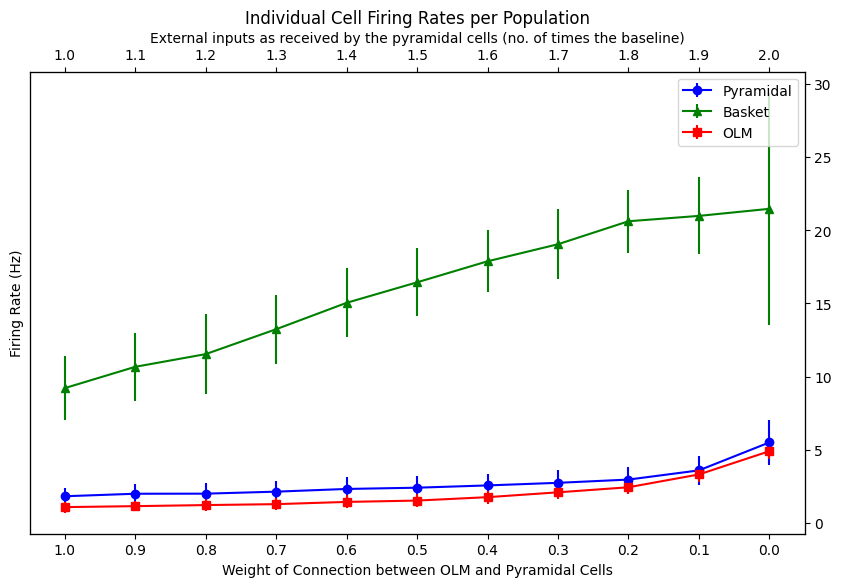

In [7]:
# Plot 1: Individual Cell Firing Rates per Population with Symbols
fig, ax1 = plt.subplots(figsize=(10, 6))
symbols = ["o", "^", "s"]  # Symbols for pyramidal, basket, and OLM cells
colors = ["b", "g", "r"]  # Colors for pyramidal, basket, and OLM cells

for i, (mean_rates, std_rates, symbol, color) in enumerate(
    zip(
        [
            pyr_mean_firing_rates_list,
            bwb_mean_firing_rates_list,
            olm_mean_firing_rates_list,
        ],
        [
            pyr_std_firing_rates_list,
            bwb_std_firing_rates_list,
            olm_std_firing_rates_list,
        ],
        symbols,
        colors,
    )
):
    ax1.errorbar(
        np.arange(len(mean_rates)),
        mean_rates,
        yerr=std_rates,
        marker=symbol,
        color=color,
        label=f'{["Pyramidal", "Basket", "OLM"][i]}',
    )

# Primary x-axis (bottom)
ax1.set_xlabel("Weight of Connection between OLM and Pyramidal Cells")
ax1.set_ylabel("Firing Rate (Hz)")
ax1.set_title("Individual Cell Firing Rates per Population")
ax1.set_xticks(np.arange(len(olm_pyr_weights)))
ax1.set_xticklabels([f"{w:.1f}" for w in olm_pyr_weights])
ax1.legend()

# Hide the primary y-axis
ax1.yaxis.set_ticks([])  # Hide y-axis ticks
ax1.yaxis.set_ticklabels([])  # Hide y-axis tick labels

# Add secondary y-axis on the right side
ax_right = ax1.twinx()
ax_right.set_ylim(*ax1.get_ylim())  # Ensure the secondary y-axis has the same limits

# Secondary x-axis (top)
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(len(noise_w)))
ax2.set_xticklabels([f"{w:.1f}" for w in noise_w])
ax2.set_xlabel(
    "External inputs as received by the pyramidal cells (no. of times the baseline)"
)

plt.show()

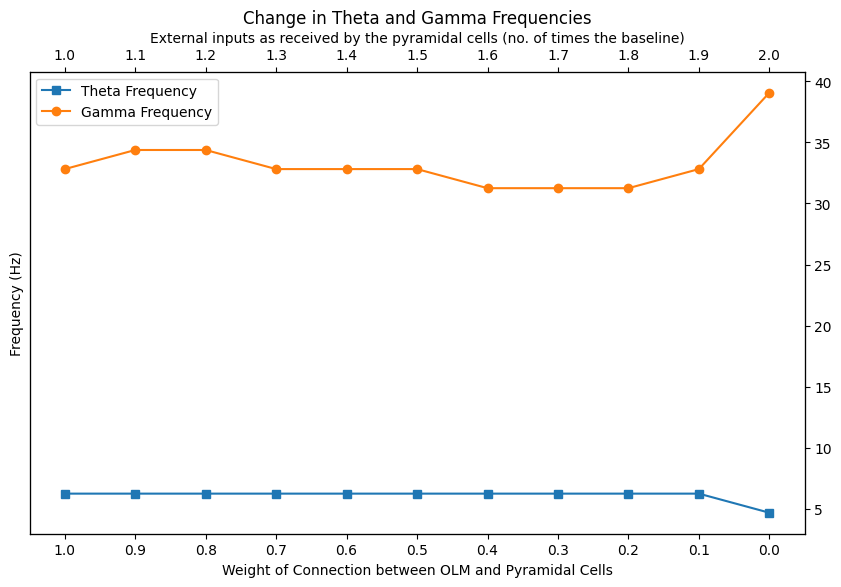

In [8]:
# Plot 2: Change in Theta and Gamma Frequencies
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary x-axis (bottom)
ax1.plot(
    np.arange(len(theta_frequencies_list)),
    theta_frequencies_list,
    marker="s",
    linestyle="-",
    label="Theta Frequency",
)
ax1.plot(
    np.arange(len(gamma_frequencies_list)),
    gamma_frequencies_list,
    marker="o",
    linestyle="-",
    label="Gamma Frequency",
)

ax1.set_xlabel("Weight of Connection between OLM and Pyramidal Cells")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_title("Change in Theta and Gamma Frequencies")
ax1.set_xticks(np.arange(len(olm_pyr_weights)))
ax1.set_xticklabels([f"{w:.1f}" for w in olm_pyr_weights])
ax1.legend()

# Hide the primary y-axis
ax1.yaxis.set_ticks([])  # Hide y-axis ticks
ax1.yaxis.set_ticklabels([])  # Hide y-axis tick labels

# Add secondary y-axis on the right side
ax_right = ax1.twinx()
ax_right.set_ylim(*ax1.get_ylim())  # Ensure the secondary y-axis has the same limits

# Secondary x-axis (top)
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(len(noise_w)))
ax2.set_xticklabels([f"{w:.1f}" for w in noise_w])
ax2.set_xlabel(
    "External inputs as received by the pyramidal cells (no. of times the baseline)"
)

plt.show()

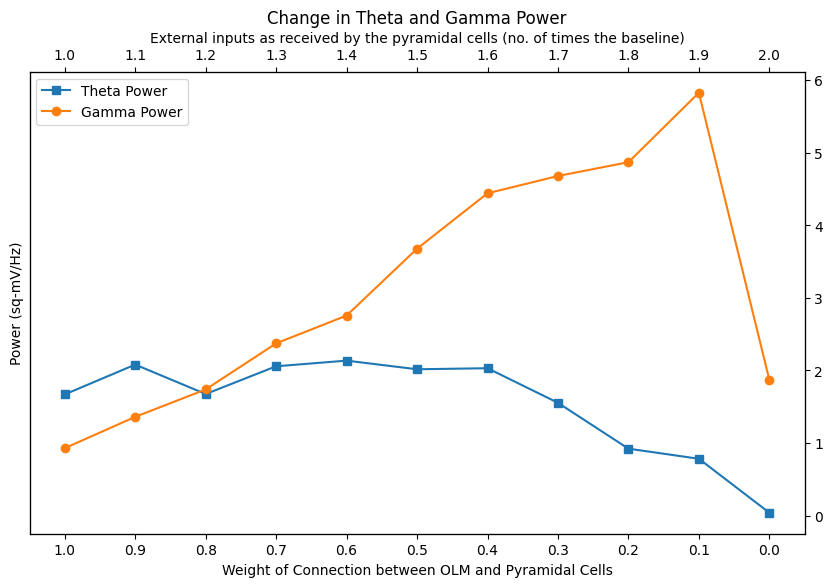

In [9]:
# Plot 3: Change in Theta and Gamma Power
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary x-axis (bottom)
ax1.plot(
    np.arange(len(mean_theta_power_list)),
    mean_theta_power_list,
    marker="s",
    linestyle="-",
    label="Theta Power",
)
ax1.plot(
    np.arange(len(mean_gamma_power_list)),
    mean_gamma_power_list,
    marker="o",
    linestyle="-",
    label="Gamma Power",
)

ax1.set_xlabel("Weight of Connection between OLM and Pyramidal Cells")
ax1.set_ylabel("Power (sq-mV/Hz)")
ax1.set_title("Change in Theta and Gamma Power")
ax1.set_xticks(np.arange(len(olm_pyr_weights)))
ax1.set_xticklabels([f"{w:.1f}" for w in olm_pyr_weights])
ax1.legend()

# Hide the primary y-axis
ax1.yaxis.set_ticks([])  # Hide y-axis ticks
ax1.yaxis.set_ticklabels([])  # Hide y-axis tick labels

# Add secondary y-axis on the right side
ax_right = ax1.twinx()
ax_right.set_ylim(*ax1.get_ylim())  # Ensure the secondary y-axis has the same limits

# Secondary x-axis (top)
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(len(noise_w)))
ax2.set_xticklabels([f"{w:.1f}" for w in noise_w])
ax2.set_xlabel(
    "External inputs as received by the pyramidal cells (no. of times the baseline)"
)

plt.show()

In [10]:
# Data frame of all the data
import pandas as pd

# Create a dataframe which has the following headers for the data in the columns: OLM-Pyr Wt, External Wt, Pyr(Hz)+ Pyr (Std), BWB (Hz)+ BWB (Std), OLM (Hz)+ OLM (Std), Theta Freq (Hz), Theta power (mV^2 Hz^-1), Gamma Freq (Hz), Gamma power (mV^2 Hz^-1)
# Create a dataframe which has the following respective data in the columns:
# olm_pyr_weights, noise_w, pyr_mean_firing_rates_list + pyr_std_firing_rates_list, bwb_mean_firing_rates_list + bwb_std_firing_rates_list, olm_mean_firing_rates_list + olm_std_firing_rates_list, theta_frequencies_list, mean_theta_power_list, gamma_frequencies_list, mean_gamma_power_list


# Create a DataFrame
df_data = {
    "OLM-Pyr Wt": [f"{val:.1f}X" for val in olm_pyr_weights],
    "External Wt": [f"{val:.1f}X" for val in noise_w],
    "Pyr(Hz)+ Pyr (Std)": [
        f"{mean:.2f}+-{std:.2f}"
        for mean, std in zip(pyr_mean_firing_rates_list, pyr_std_firing_rates_list)
    ],
    "BWB (Hz)+ BWB (Std)": [
        f"{mean:.2f}+-{std:.2f}"
        for mean, std in zip(bwb_mean_firing_rates_list, bwb_std_firing_rates_list)
    ],
    "OLM (Hz)+ OLM (Std)": [
        f"{mean:.2f}+-{std:.2f}"
        for mean, std in zip(olm_mean_firing_rates_list, olm_std_firing_rates_list)
    ],
    "Theta Freq (Hz)": [f"{freq:.1f}" for freq in theta_frequencies_list],
    "Theta power (mV^2 Hz^-1)": [f"{power[0]:.2f}" for power in mean_theta_power_list],
    "Gamma Freq (Hz)": [f"{freq:.1f}" for freq in gamma_frequencies_list],
    "Gamma power (mV^2 Hz^-1)": [f"{power[0]:.2f}" for power in mean_gamma_power_list],
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(df_data)

# Show the DataFrame
df

,OLM-Pyr Wt,External Wt,Pyr(Hz)+ Pyr (Std),BWB (Hz)+ BWB (Std),OLM (Hz)+ OLM (Std),Theta Freq (Hz),Theta power (mV^2 Hz^-1),Gamma Freq (Hz),Gamma power (mV^2 Hz^-1)
0,1.0X,1.0X,1.83+-0.58,9.21+-2.20,1.08+-0.38,6.2,1.67,32.8,0.93
1,0.9X,1.1X,2.00+-0.64,10.67+-2.31,1.15+-0.36,6.2,2.08,34.4,1.36
2,0.8X,1.2X,2.00+-0.71,11.54+-2.72,1.22+-0.39,6.2,1.67,34.4,1.74
3,0.7X,1.3X,2.14+-0.74,13.24+-2.36,1.29+-0.42,6.2,2.06,32.8,2.37
4,0.6X,1.4X,2.33+-0.79,15.04+-2.35,1.44+-0.45,6.2,2.13,32.8,2.76
5,0.5X,1.5X,2.41+-0.80,16.44+-2.31,1.53+-0.45,6.2,2.02,32.8,3.68
6,0.4X,1.6X,2.57+-0.79,17.88+-2.12,1.76+-0.45,6.2,2.03,31.2,4.44
7,0.3X,1.7X,2.74+-0.86,19.04+-2.38,2.10+-0.49,6.2,1.55,31.2,4.68
8,0.2X,1.8X,2.97+-0.88,20.61+-2.14,2.44+-0.48,6.2,0.92,31.2,4.87
9,0.1X,1.9X,3.59+-0.99,20.98+-2.62,3.31+-0.50,6.2,0.78,32.8,5.82


In [11]:
# save path for df
directory_path = "../Tables/Model_validation"
dataframe_and_filename = (df), "Sanjay_validation.csv"

# Check if the directory exists and create it if not
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

for df, filename in dataframe_and_filename:
    full_path = f"{directory_path}/{filename}"
    df.to_csv(full_path, index=False)

In [12]:
# for lfp in lfps_list:
#     # Plot the LFP
#     plt.figure(figsize=(10, 5))
#     plt.plot(lfp, label='LFP')
#     plt.title('Local Field Potential (LFP)')
#     plt.xlabel('Time Steps')
#     plt.ylabel('Voltage (mV)')
#     plt.grid(True)